In [1]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

sys.path.append("..")
from utils.util_functions import *

# MLB

In [2]:
event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")

In [3]:
df = event_df[event_df.攻撃チーム==team]
team = "Rソックス"
columns = list(df.columns)
case_index = columns.index("状況")
try:
    inning_index = columns.index("イニング")
except:
    inning_index = columns.index("回")
top_index = columns.index("表得点")
bot_index = columns.index("裏得点")

inning_list = []
for inning in range(18):
    curr_inning_list = []
    for i in range(len(df)):
        if df.iloc[i, case_index] == "GAMESET":
            continue
        if int(df.iloc[i, inning_index].split("回")[0]) == inning + 1:
            try:
                curr_inning_list.append((df.iloc[i, case_index], abs(int(df.iloc[i, top_index])-int(df.iloc[i, bot_index]))))
            except:
                curr_inning_list.append((df.iloc[i, case_index], np.nan))
    inning_list.append(curr_inning_list)

NameError: name 'team' is not defined

In [ ]:
pd.DataFrame(inning_list[6]).describe()

In [ ]:
team = "Rソックス"
df = event_df[event_df.攻撃チーム==team]
triple = make_inning_triple(make_inning_list(df, score_end=4))
lst = make_flattened_list(triple)

In [ ]:
len(triple)

In [ ]:
df = pd.DataFrame(lst)
score_diff = df[1].apply(lambda x: x[1])
df = df.applymap(lambda x: x[0])
df["点差"] = score_diff
df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]

In [ ]:
len(df_with_score[df_with_score.点差<=1][[0, 1, 2]].values.tolist())

# 回点差指定せず、流れのいい時だけ

In [4]:
diffs = []
stds = []
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = [elem for elem in df_with_score[df_with_score.点差<=30][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team).describe()[column]["std"] / make_score_df_mlb(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)

インディアンス -0.08157798040847819 0.709479335467
ヤンキース -0.0606708653691479 0.61072599013
ブリュワーズ -0.07645973714723464 0.670083659328
Dバックス -0.08239934385344938 0.708102395369
マーリンズ -0.08771579470960411 0.745161351662
オリオールズ -0.08066092339985564 0.781906801829
エンゼルス -0.07349794535863863 0.692139970806
マリナーズ -0.07304825054929154 0.668948069586
ツインズ -0.07473313973320961 0.649470212774
Rソックス -0.08242329184829611 0.669210021299
アストロズ -0.07010075527057102 0.684975274055
レンジャーズ -0.08955343274477956 0.714067340083
パドレス -0.07846243444662182 0.668453678081
ナショナルズ -0.07246546075103044 0.795189195443
ドジャース -0.07369729517580126 0.697131500955
ロッキーズ -0.07345831755133458 0.6973869369
ジャイアンツ -0.08155565924049801 0.737955073316
メッツ -0.06860138520469894 0.735159694044
ブルージェイズ -0.07965802901946395 0.666022782951
レイズ -0.06766574815534998 0.70014369491
ブレーブス -0.08359956295095028 0.70938418131
フィリーズ -0.07547764397933543 0.72758841746
レッズ -0.0812904453924399 0.678095136226
ロイヤルズ -0.07574166954053752 0.757228903468

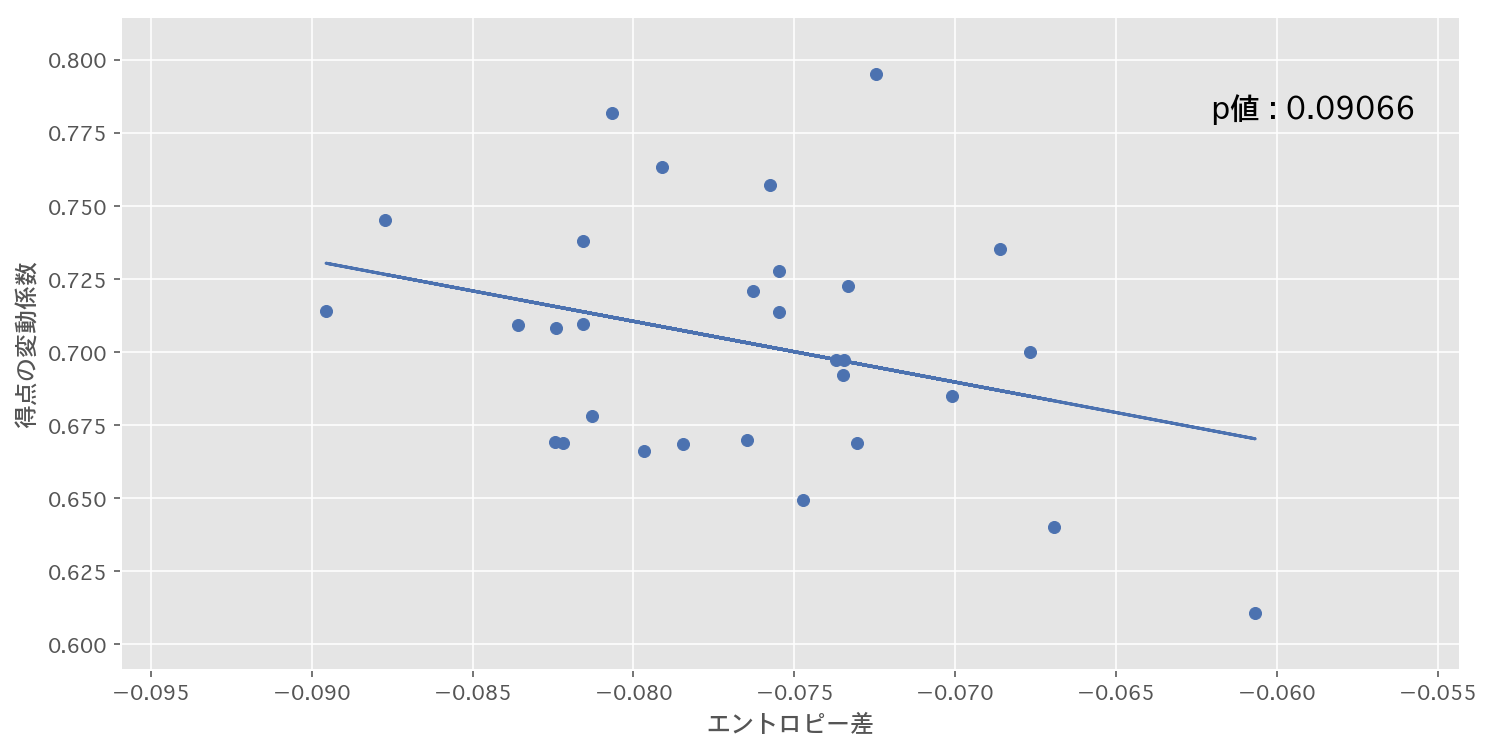

In [5]:
import statsmodels.api as sm

plt.figure(figsize=(12, 6))

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.xlabel("エントロピー差")
plt.ylabel("得点の変動係数")
plt.text(x=-0.062, y=0.78, s="p値 : "+str(results.pvalues[1])[:7], fontsize=15)
plt.show()

# 5回以降だけ考えて点差気にせず・流れのいい時だけ

In [6]:
diffs = []
stds = []
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[4:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = [elem for elem in df_with_score[df_with_score.点差<=30][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team).describe()[column]["std"] / make_score_df_mlb(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)

インディアンス -0.10731633071348723 0.709479335467
ヤンキース -0.0960909480893104 0.61072599013
ブリュワーズ -0.0989537106555316 0.670083659328
Dバックス -0.11853305491302812 0.708102395369
マーリンズ -0.11630006835877582 0.745161351662
オリオールズ -0.1066082316160184 0.781906801829
エンゼルス -0.11591667953140528 0.692139970806
マリナーズ -0.1079122647636308 0.668948069586
ツインズ -0.1045530687673848 0.649470212774
Rソックス -0.10523789622169843 0.669210021299
アストロズ -0.10680861376380602 0.684975274055
レンジャーズ -0.11963993885717583 0.714067340083
パドレス -0.09774871469312796 0.668453678081
ナショナルズ -0.10997278944401767 0.795189195443
ドジャース -0.10867416353253079 0.697131500955
ロッキーズ -0.10149407608069483 0.6973869369
ジャイアンツ -0.1144333905722541 0.737955073316
メッツ -0.10222733565524234 0.735159694044
ブルージェイズ -0.12009352121682149 0.666022782951
レイズ -0.0936344499631172 0.70014369491
ブレーブス -0.11600885105135772 0.70938418131
フィリーズ -0.10611000154103456 0.72758841746
レッズ -0.10296194272814718 0.678095136226
ロイヤルズ -0.10848140914479965 0.757228903468
カブス 

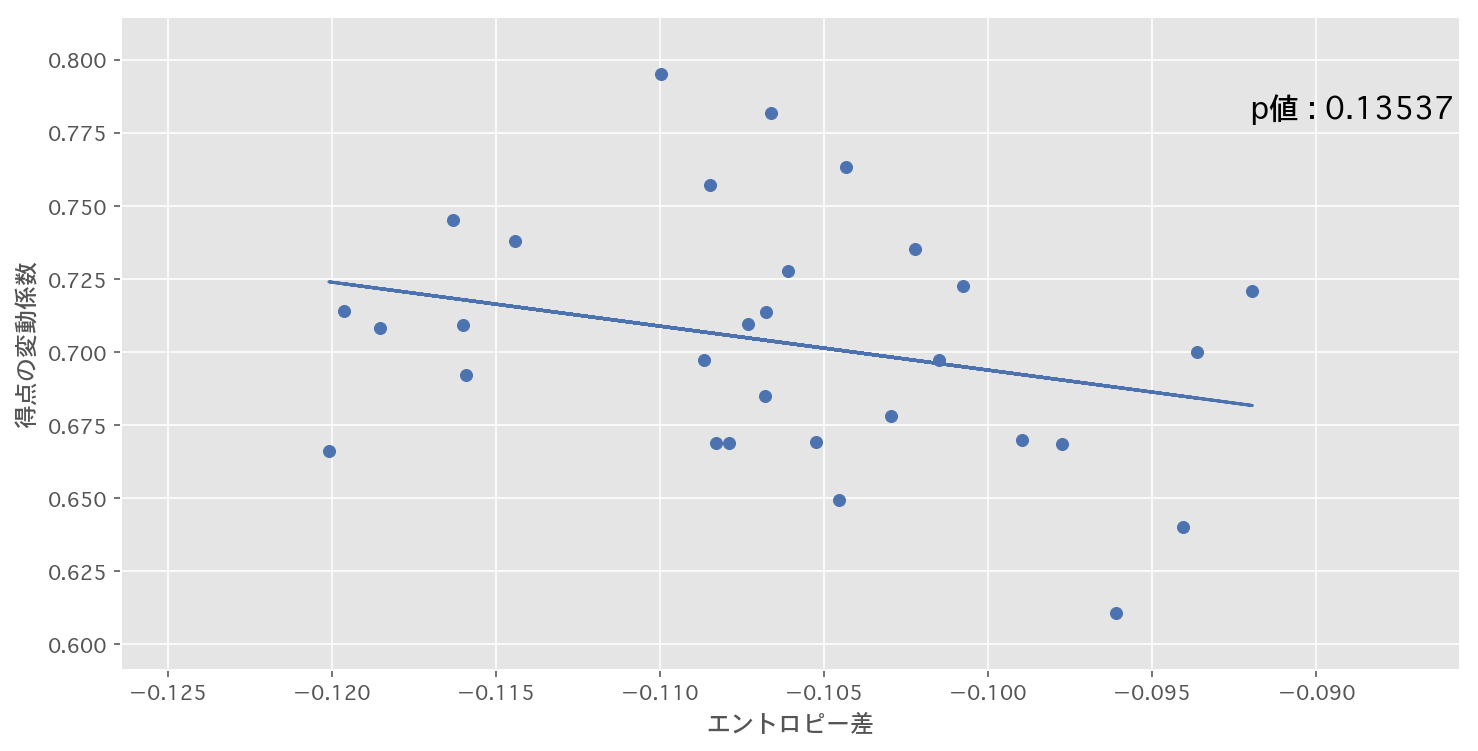

In [7]:
import statsmodels.api as sm

plt.figure(figsize=(12, 6))

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.xlabel("エントロピー差")
plt.ylabel("得点の変動係数")
plt.text(x=-0.092, y=0.78, s="p値 : "+str(results.pvalues[1])[:7], fontsize=15)
plt.show()

# 回を気にせず4点差いない・流れがいい時

In [8]:
diffs = []
stds = []
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = [elem for elem in df_with_score[df_with_score.点差<=4][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team).describe()[column]["std"] / make_score_df_mlb(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)

インディアンス -0.08992412641946324 0.709479335467
ヤンキース -0.06761698759768375 0.61072599013
ブリュワーズ -0.08053996916948325 0.670083659328
Dバックス -0.09237403999482963 0.708102395369
マーリンズ -0.09527513654088038 0.745161351662
オリオールズ -0.08879829602285083 0.781906801829
エンゼルス -0.08029237413800061 0.692139970806
マリナーズ -0.07988697870181527 0.668948069586
ツインズ -0.07974508262914837 0.649470212774
Rソックス -0.09450154515992448 0.669210021299
アストロズ -0.07358053589991043 0.684975274055
レンジャーズ -0.09928277255042683 0.714067340083
パドレス -0.08746652795965959 0.668453678081
ナショナルズ -0.078885181969921 0.795189195443
ドジャース -0.07710327006814888 0.697131500955
ロッキーズ -0.08397384452257084 0.6973869369
ジャイアンツ -0.08764957582439026 0.737955073316
メッツ -0.07845831663144365 0.735159694044
ブルージェイズ -0.08347921534225566 0.666022782951
レイズ -0.07411838693562478 0.70014369491
ブレーブス -0.08469244357179351 0.70938418131
フィリーズ -0.0813214906210904 0.72758841746
レッズ -0.08932053425143982 0.678095136226
ロイヤルズ -0.08252043953354171 0.757228903468


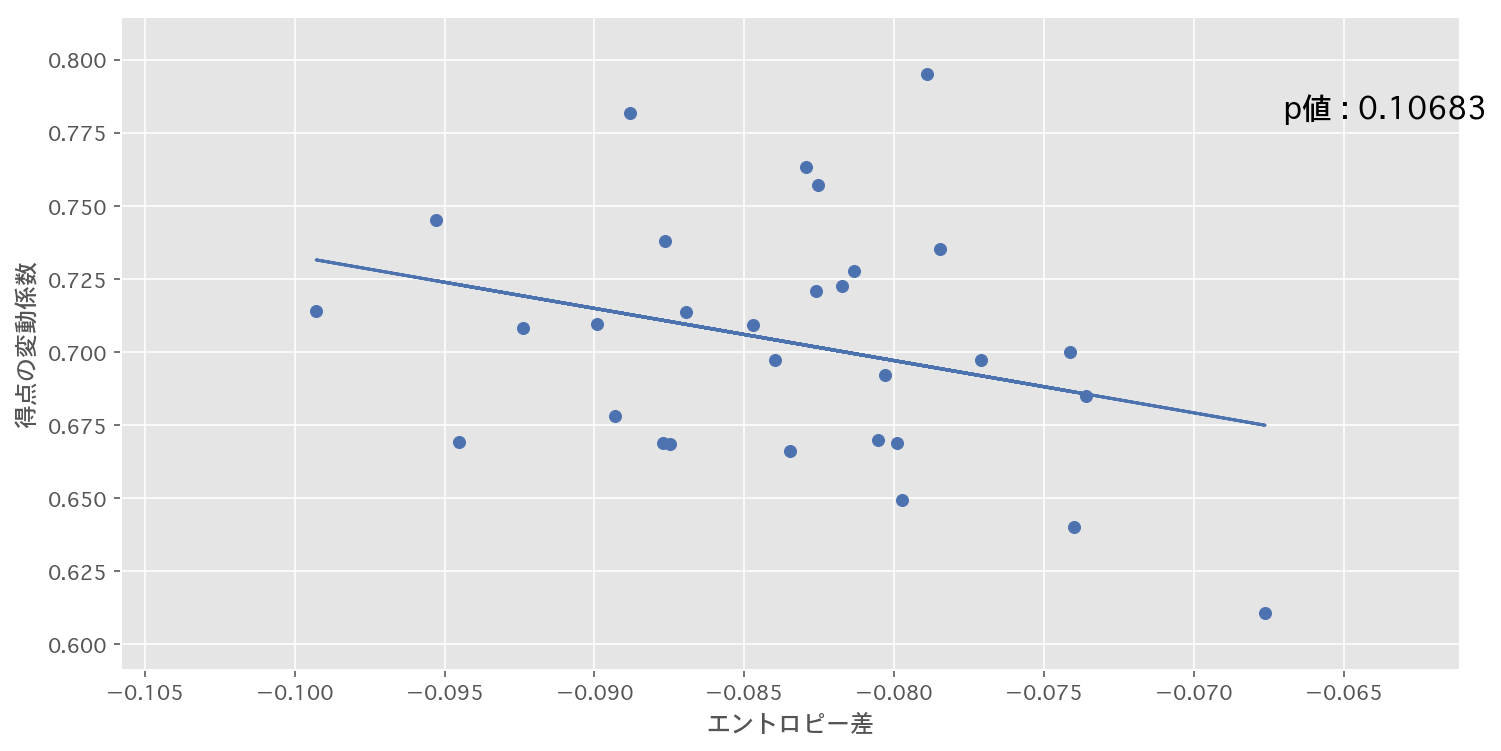

In [9]:
import statsmodels.api as sm

plt.figure(figsize=(12, 6))

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.xlabel("エントロピー差")
plt.ylabel("得点の変動係数")
plt.text(x=-0.067, y=0.78, s="p値 : "+str(results.pvalues[1])[:7], fontsize=15)
plt.show()

# 5回以降の4点差いないの状況で、流れがいい時

In [10]:
diffs = []
stds = []
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[4:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = [elem for elem in df_with_score[df_with_score.点差<=4][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team).describe()[column]["std"] / make_score_df_mlb(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)

インディアンス -0.1135014941598067 0.709479335467
ヤンキース -0.10498631948118753 0.61072599013
ブリュワーズ -0.10276667600302813 0.670083659328
Dバックス -0.13707685354680477 0.708102395369
マーリンズ -0.1386974764752935 0.745161351662
オリオールズ -0.12358178991148616 0.781906801829
エンゼルス -0.1349744423416266 0.692139970806
マリナーズ -0.11812919397230148 0.668948069586
ツインズ -0.11657893540231168 0.649470212774
Rソックス -0.11840250521938733 0.669210021299
アストロズ -0.10954149197253615 0.684975274055
レンジャーズ -0.13833851278945897 0.714067340083
パドレス -0.10729725454528172 0.668453678081
ナショナルズ -0.12027577904568965 0.795189195443
ドジャース -0.11366732296132342 0.697131500955
ロッキーズ -0.10944395876506663 0.6973869369
ジャイアンツ -0.13394652917818783 0.737955073316
メッツ -0.11825976959557316 0.735159694044
ブルージェイズ -0.13059228438322545 0.666022782951
レイズ -0.10536807039621765 0.70014369491
ブレーブス -0.1251608166118201 0.70938418131
フィリーズ -0.12348719459496937 0.72758841746
レッズ -0.11559761873979824 0.678095136226
ロイヤルズ -0.12182459184218652 0.757228903468
カ

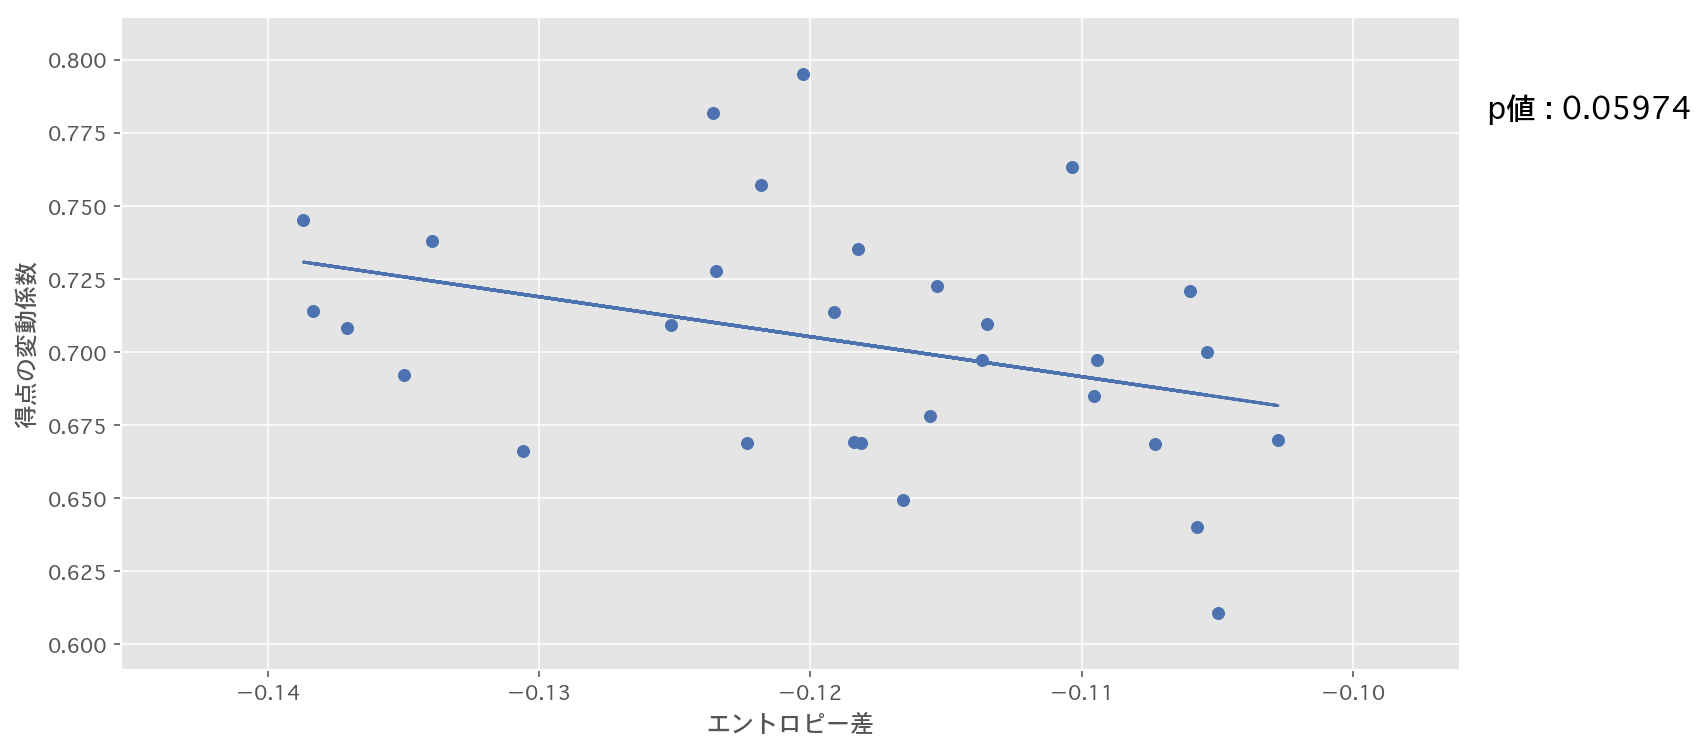

In [11]:
import statsmodels.api as sm

plt.figure(figsize=(12, 6))

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.xlabel("エントロピー差")
plt.ylabel("得点の変動係数")
plt.text(x=-0.095, y=0.78, s="p値 : "+str(results.pvalues[1])[:7], fontsize=15)
plt.show()

# 5回以降の4点差いないの状況、流れの良し悪しは見てない

In [12]:
diffs = []
stds = []
for team in teams_mlb:
    df = event_df[event_df.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[4:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = df_with_score[df_with_score.点差<=2][[0, 1, 2]].values.tolist()
    #improved_lst = [elem for elem in df_with_score[df_with_score.点差<=2][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team).describe()[column]["std"] / make_score_df_mlb(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)


インディアンス -0.14591346407550487 0.709479335467
ヤンキース -0.15214463465848382 0.61072599013
ブリュワーズ -0.14276671591513157 0.670083659328
Dバックス -0.1666345970715919 0.708102395369
マーリンズ -0.1826643786838682 0.745161351662
オリオールズ -0.1438348586661089 0.781906801829
エンゼルス -0.17918980757720382 0.692139970806
マリナーズ -0.15711172005569907 0.668948069586
ツインズ -0.15273664549793242 0.649470212774
Rソックス -0.17010686288033394 0.669210021299
アストロズ -0.1726757324316388 0.684975274055
レンジャーズ -0.18686727549264326 0.714067340083
パドレス -0.16405465288809395 0.668453678081
ナショナルズ -0.16790508352854738 0.795189195443
ドジャース -0.1561775294255816 0.697131500955
ロッキーズ -0.1645292326716854 0.6973869369
ジャイアンツ -0.1493546258004943 0.737955073316
メッツ -0.15580442211064804 0.735159694044
ブルージェイズ -0.1769886534391527 0.666022782951
レイズ -0.16167702014280438 0.70014369491
ブレーブス -0.171835758452219 0.70938418131
フィリーズ -0.15954931050107923 0.72758841746
レッズ -0.18787403736133168 0.678095136226
ロイヤルズ -0.16066103003814236 0.757228903468
カブス -0.

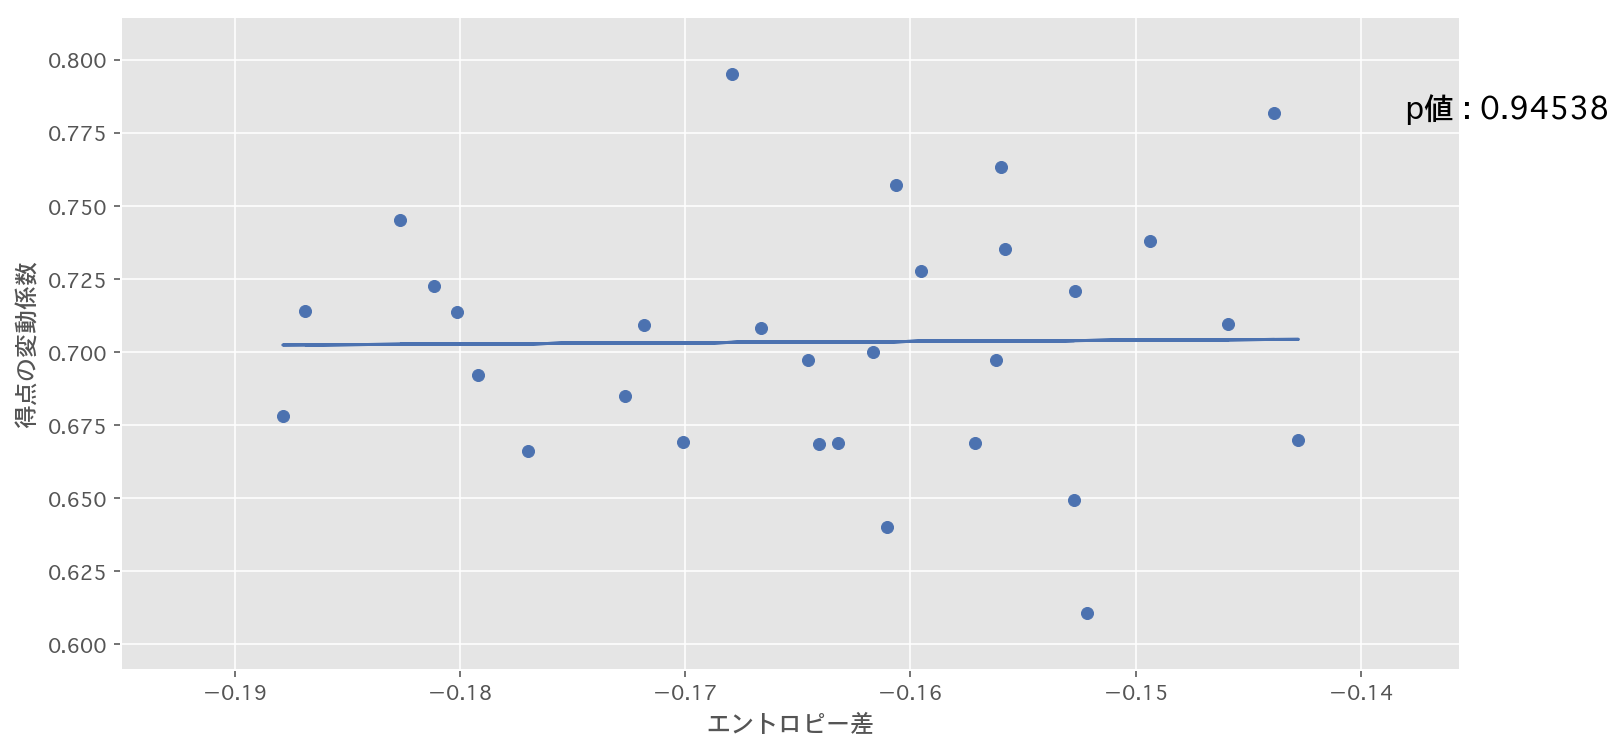

In [13]:
    
import statsmodels.api as sm

plt.figure(figsize=(12, 6))

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.xlabel("エントロピー差")
plt.ylabel("得点の変動係数")
plt.text(x=-0.138, y=0.78, s="p値 : "+str(results.pvalues[1])[:7], fontsize=15)
plt.show()

# 

In [14]:
diffs = []
stds = []
"""
for team in teams_mlb:
    df = df_2017[df_2017.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[4:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = [elem for elem in df_with_score[df_with_score.点差<=4][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team, 2017).describe()[column]["std"] / make_score_df_mlb(team, 2017).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)
"""
for team in teams_mlb:
    df = df_2018[df_2018.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=4))
    lst = make_flattened_list(triple[4:])
    df = pd.DataFrame(lst)
    score_diff = df[1].apply(lambda x: x[1])
    df = df.applymap(lambda x: x[0])
    df["点差"] = score_diff
    df_with_score = df[(df[0]!="3000") & (df[1]!="3000")]
    improved_lst = [elem for elem in df_with_score[df_with_score.点差<=4][[0, 1, 2]].values.tolist() if is_improved(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team, 2018).describe()[column]["std"] / make_score_df_mlb(team, 2018).describe()[column]["mean"]
    diffs.append(second_cond_entropy-first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy-first_cond_entropy, std)

インディアンス -0.14947914263008943 0.726463434687
ヤンキース -0.13251774065656052 0.547909769625
ブリュワーズ -0.12173986598807796 0.700645228329
Dバックス -0.1660034012794136 0.71856002575
マーリンズ -0.12894413820042727 0.733353859821
オリオールズ -0.16494024036139665 0.848146059485
エンゼルス -0.16940692095393217 0.726874887421
マリナーズ -0.14511692891024586 0.651219045998
ツインズ -0.1601662287494725 0.639182765683
Rソックス -0.1688039683963356 0.667728044921
アストロズ -0.14418729824378396 0.654168783787
レンジャーズ -0.16944079633239095 0.779277092863
パドレス -0.11927582537430004 0.668012755947
ナショナルズ -0.16881558974268795 0.815253052144
ドジャース -0.12873247237400776 0.752206340683
ロッキーズ -0.1391905780592504 0.6754229857
ジャイアンツ -0.14118776252585707 0.733145630832
メッツ -0.15507249517769717 0.802488858453
ブルージェイズ -0.16620184714594455 0.678415649609
レイズ -0.12927054709035168 0.722119648926
ブレーブス -0.1519198813525291 0.698804842567
フィリーズ -0.14253883025135128 0.774675633336
レッズ -0.1512824983676544 0.699232763933
ロイヤルズ -0.14552650140919843 0.702884289545


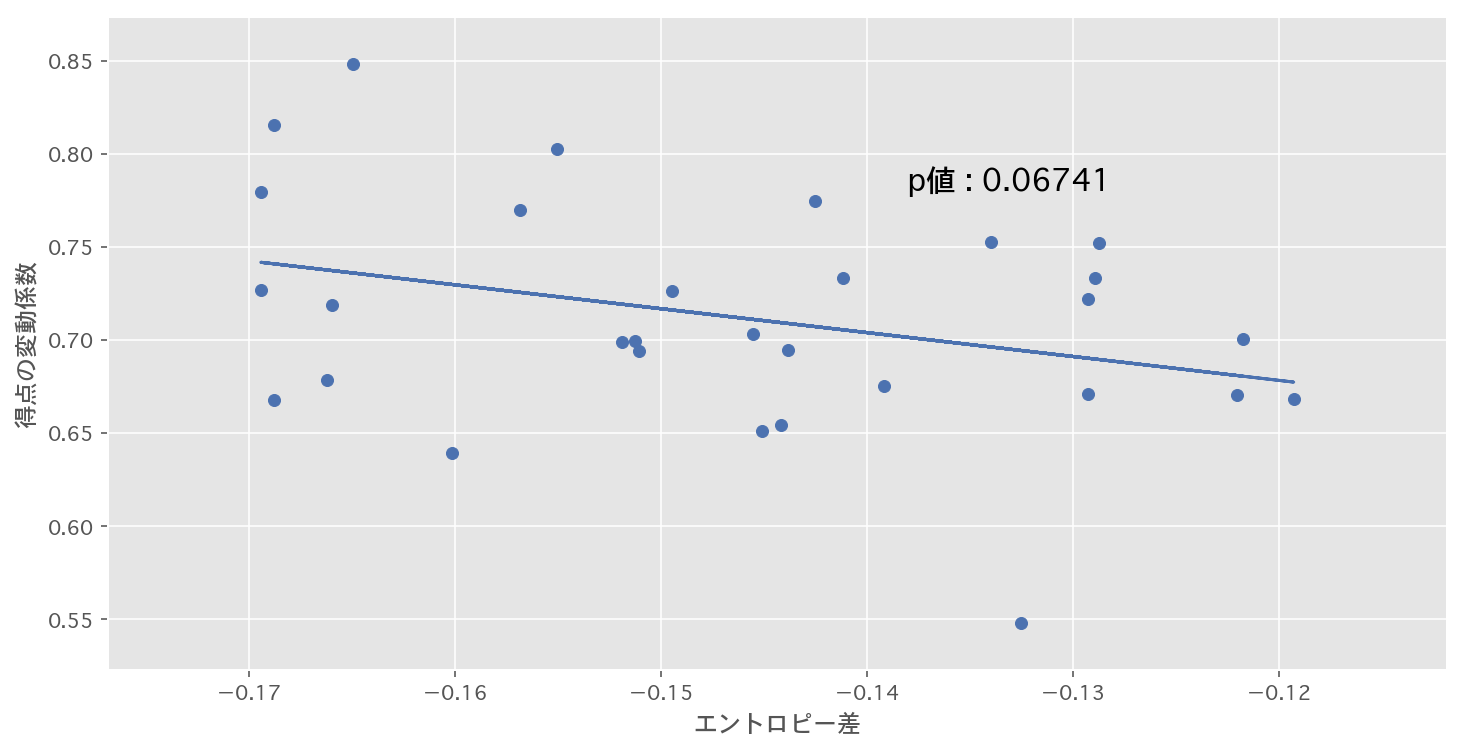

In [15]:
    
import statsmodels.api as sm

plt.figure(figsize=(12, 6))

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.xlabel("エントロピー差")
plt.ylabel("得点の変動係数")
plt.text(x=-0.138, y=0.78, s="p値 : "+str(results.pvalues[1])[:7], fontsize=15)
plt.show()

In [16]:
pd.DataFrame([diffs, stds, teams_mlb]).T.sort_values(0)

,0,1,2
11,-0.169441,0.779277,レンジャーズ
6,-0.169407,0.726875,エンゼルス
13,-0.168816,0.815253,ナショナルズ
9,-0.168804,0.667728,Rソックス
18,-0.166202,0.678416,ブルージェイズ
3,-0.166003,0.71856,Dバックス
5,-0.16494,0.848146,オリオールズ
8,-0.160166,0.639183,ツインズ
24,-0.156834,0.769608,カブス
17,-0.155072,0.802489,メッツ


In [17]:
%%latex

$$
    \text{エントロピー差} = H(S_{t+1}|S_{t}, S_{t-1}) - H(S_{t+1}|S_{t})
$$

<IPython.core.display.Latex object>